# **1. Environment Setup and Data Loading**

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

# For feature selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor

# For modeling
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.cluster import KMeans

# For model explainability
import shap
from lime import lime_tabular

# Set visualization style
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')

# Load the dataset
df = pd.read_excel('Aviation_KPIs_Dataset.xlsx')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (200000, 18)


,Flight Number,Scheduled Departure Time,Actual Departure Time,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),Revenue (USD),Operating Cost (USD),Net Profit Margin (%),Ancillary Revenue (USD),Debt-to-Equity Ratio,Revenue per ASK,Cost per ASK,Profit (USD)
0,FL885,2024-05-20 11:51:21.328,2024-07-10 02:38:53.731,50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26,-16893.84
1,FL930,2024-01-23 06:56:22.686,2024-07-07 02:53:44.150,27,14.53,83,98.59,80.49,1.55,3.93,31597.25,1564.41,7.70,2941.32,2.89,8040.01,398.07,30032.84
2,FL478,2024-05-30 09:18:38.578,2024-12-05 01:00:54.473,108,10.73,87,67.44,97.90,2.06,4.26,13700.27,30494.88,5.84,1920.45,1.34,3216.03,7158.42,-16794.61
3,FL637,2024-08-15 05:21:46.814,2024-09-21 13:23:41.615,64,15.10,99,69.01,80.17,6.85,4.13,39913.01,13444.09,24.09,3167.79,0.60,9664.17,3255.23,26468.92
4,FL318,2024-07-25 15:29:58.467,2024-03-21 15:05:54.375,30,13.46,114,50.36,82.23,7.30,4.97,11531.48,34668.98,7.18,619.80,0.84,2320.22,6975.65,-23137.50


In [8]:
!pip install lime

In [9]:
!pip install scikit-optimize

# **2. Exploratory Data Analysis**

In [10]:
# Display summary statistics
print("Summary statistics:")
df.describe().T

Summary statistics:


,count,mean,min,25%,50%,75%,max,std
Scheduled Departure Time,200000,2024-06-29 07:21:27.047897856,2024-01-01 00:01:53.341000,2024-03-30 22:12:47.147000064,2024-06-29 10:33:27.125000192,2024-09-27 09:33:27.652499968,2024-12-27 05:14:38.598000,NaN
Actual Departure Time,200000,2024-06-29 08:55:04.198966016,2024-01-01 00:03:33.981000,2024-03-30 15:40:28.572750080,2024-06-28 20:10:25.013499904,2024-09-28 03:54:08.405749760,2024-12-27 05:07:36.226000,NaN
Delay (Minutes),200000.0,59.35885,0.0,29.0,59.0,89.0,119.0,34.67602
Aircraft Utilization (Hours/Day),200000.0,12.003438,8.0,9.99,12.01,14.01,16.0,2.311966
Turnaround Time (Minutes),200000.0,74.45168,30.0,52.0,74.0,97.0,119.0,25.977826
Load Factor (%),200000.0,74.997178,50.0,62.5,74.96,87.53,100.0,14.439393
Fleet Availability (%),200000.0,85.001378,70.0,77.48,85.0,92.53,100.0,8.672413
Maintenance Downtime (Hours),200000.0,5.503103,1.0,3.25,5.5,7.76,10.0,2.601257
Fuel Efficiency (ASK),200000.0,3.496959,2.0,2.75,3.49,4.25,5.0,0.865309
Revenue (USD),200000.0,25571.448338,1000.06,13297.0425,25566.3,37860.4025,49999.95,14158.512116


In [11]:
# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values,
                           'Percentage': missing_percent})
missing_df[missing_df['Missing Values'] > 0]


Missing values per column:


,Missing Values,Percentage


In [12]:
# Check data types
print("\nData types:")
df.dtypes


Data types:


,0
Flight Number,object
Scheduled Departure Time,datetime64[ns]
Actual Departure Time,datetime64[ns]
Delay (Minutes),int64
Aircraft Utilization (Hours/Day),float64
Turnaround Time (Minutes),int64
Load Factor (%),float64
Fleet Availability (%),float64
Maintenance Downtime (Hours),float64
Fuel Efficiency (ASK),float64


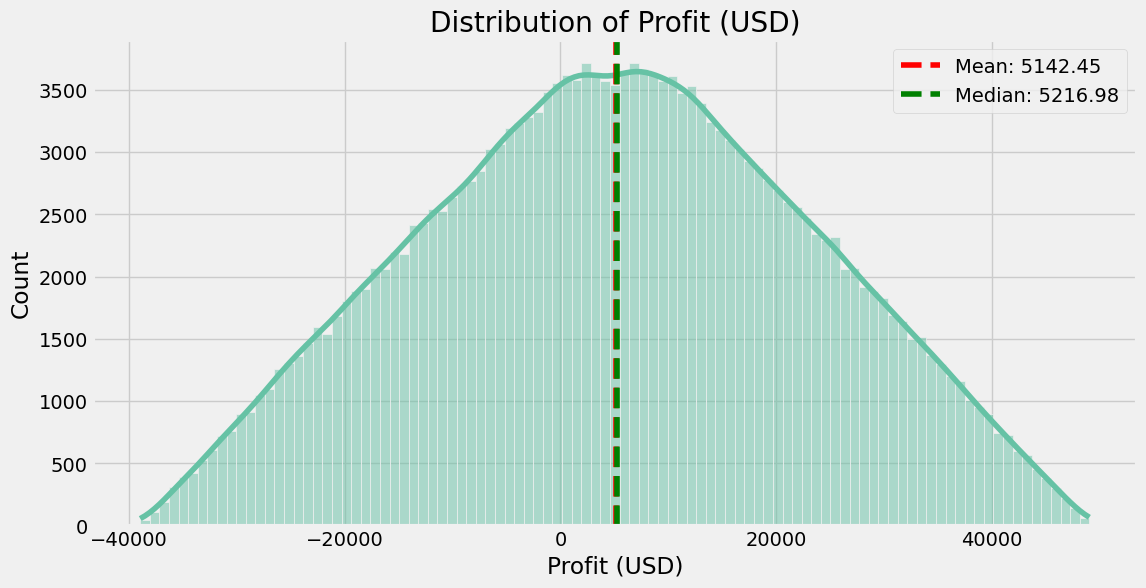

In [13]:
# Visualize distribution of target variable (Profit)
plt.figure(figsize=(12, 6))
sns.histplot(df['Profit (USD)'], kde=True)
plt.title('Distribution of Profit (USD)')
plt.axvline(df['Profit (USD)'].mean(), color='red', linestyle='--', label=f'Mean: {df["Profit (USD)"].mean():.2f}')
plt.axvline(df['Profit (USD)'].median(), color='green', linestyle='--', label=f'Median: {df["Profit (USD)"].median():.2f}')
plt.legend()
plt.show()


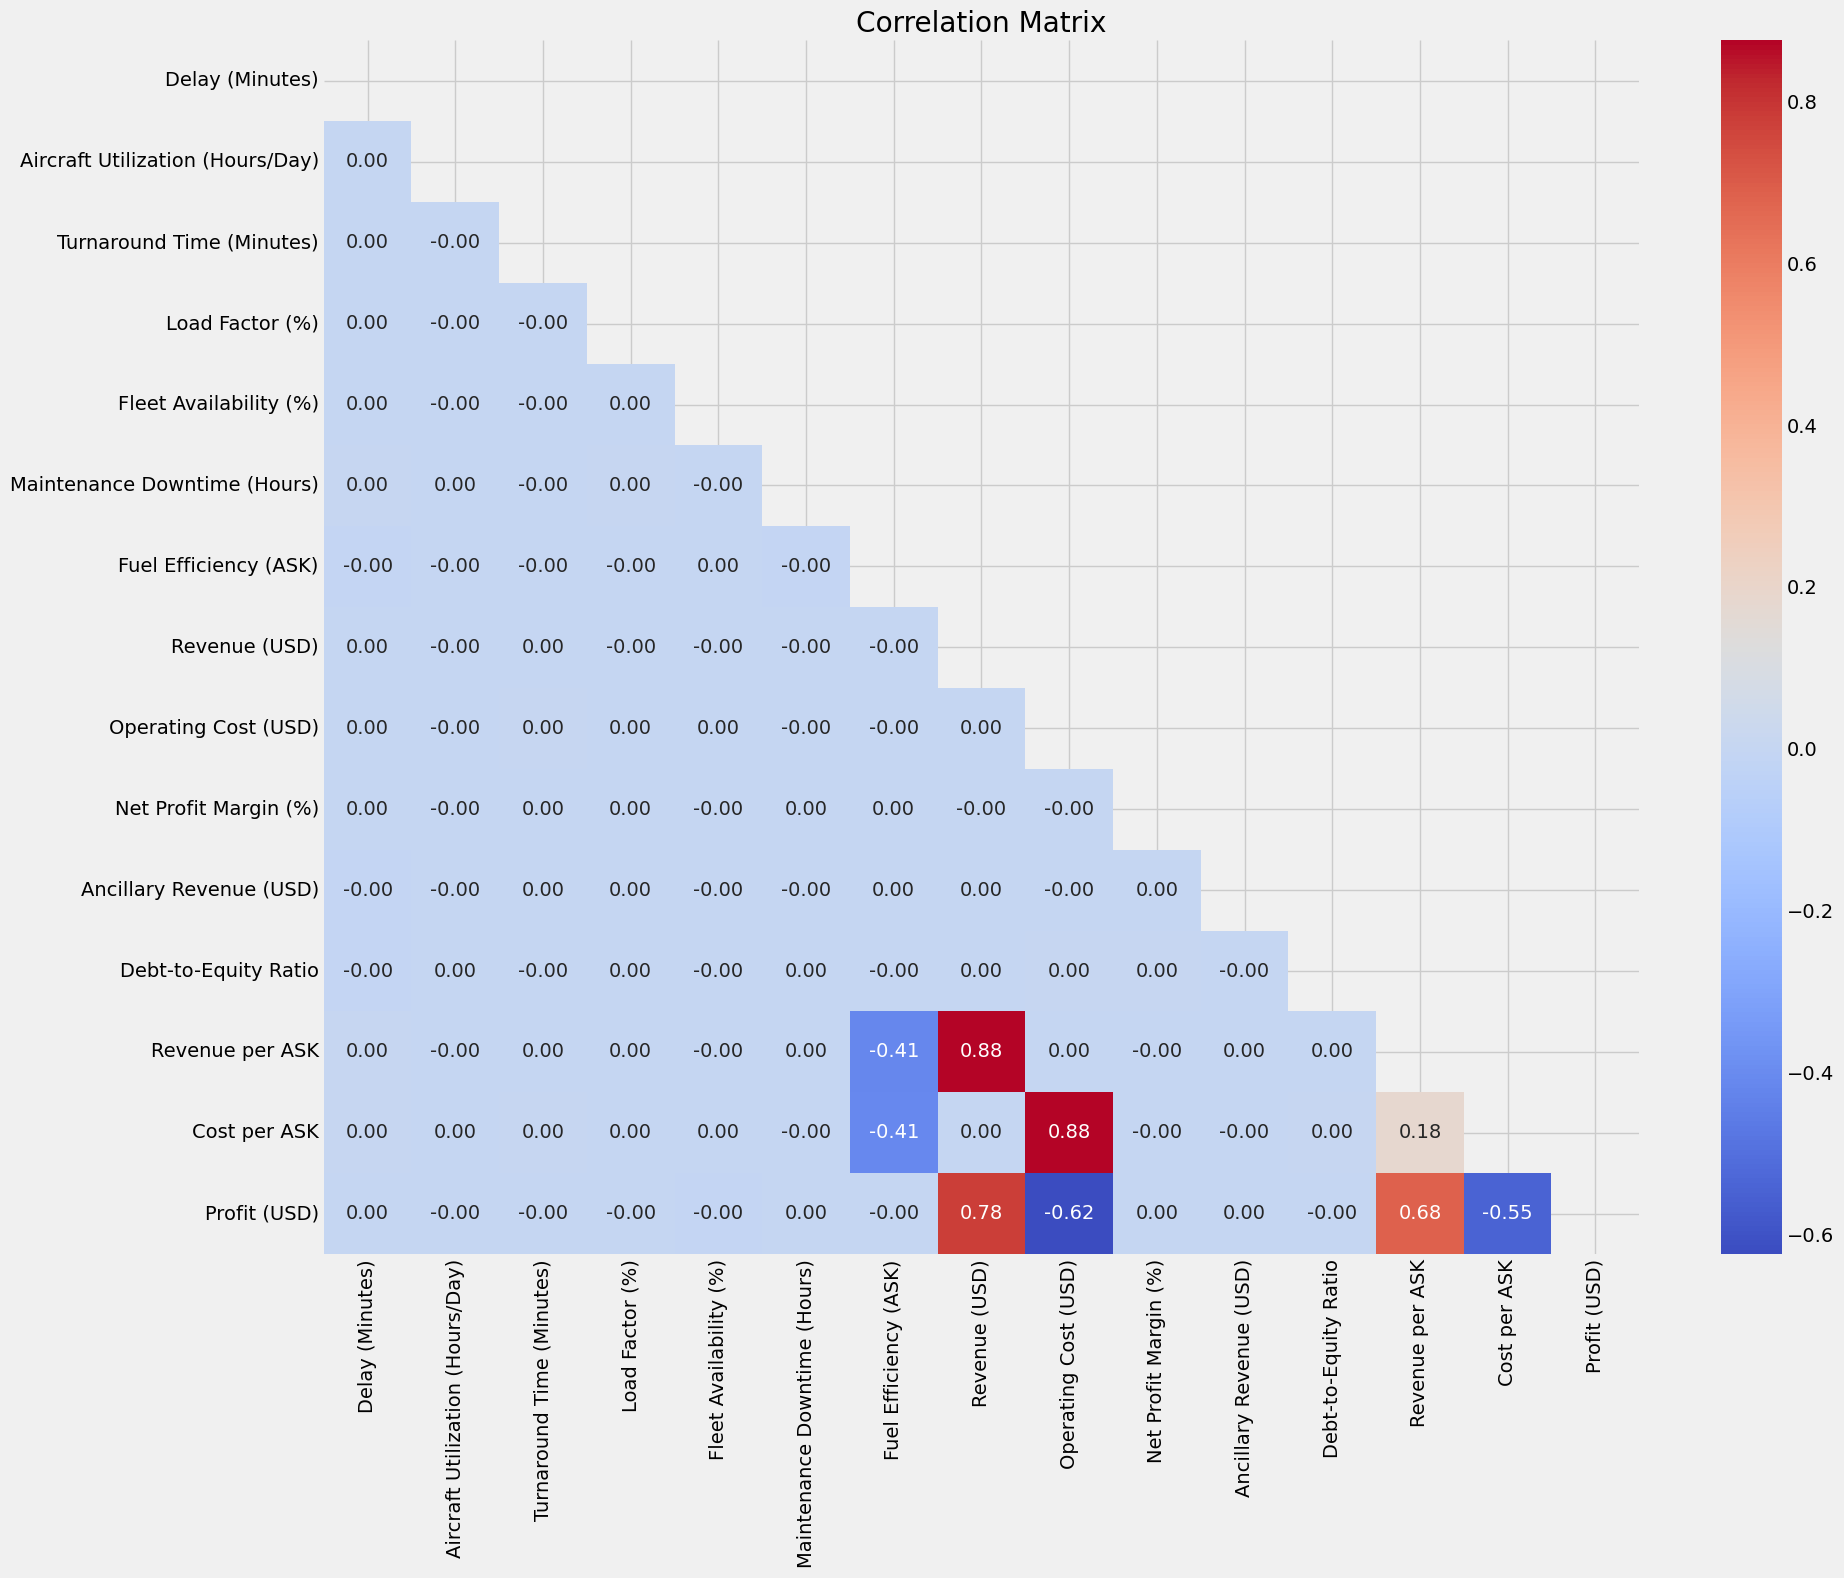

In [14]:
# Correlation analysis
plt.figure(figsize=(20, 16))
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

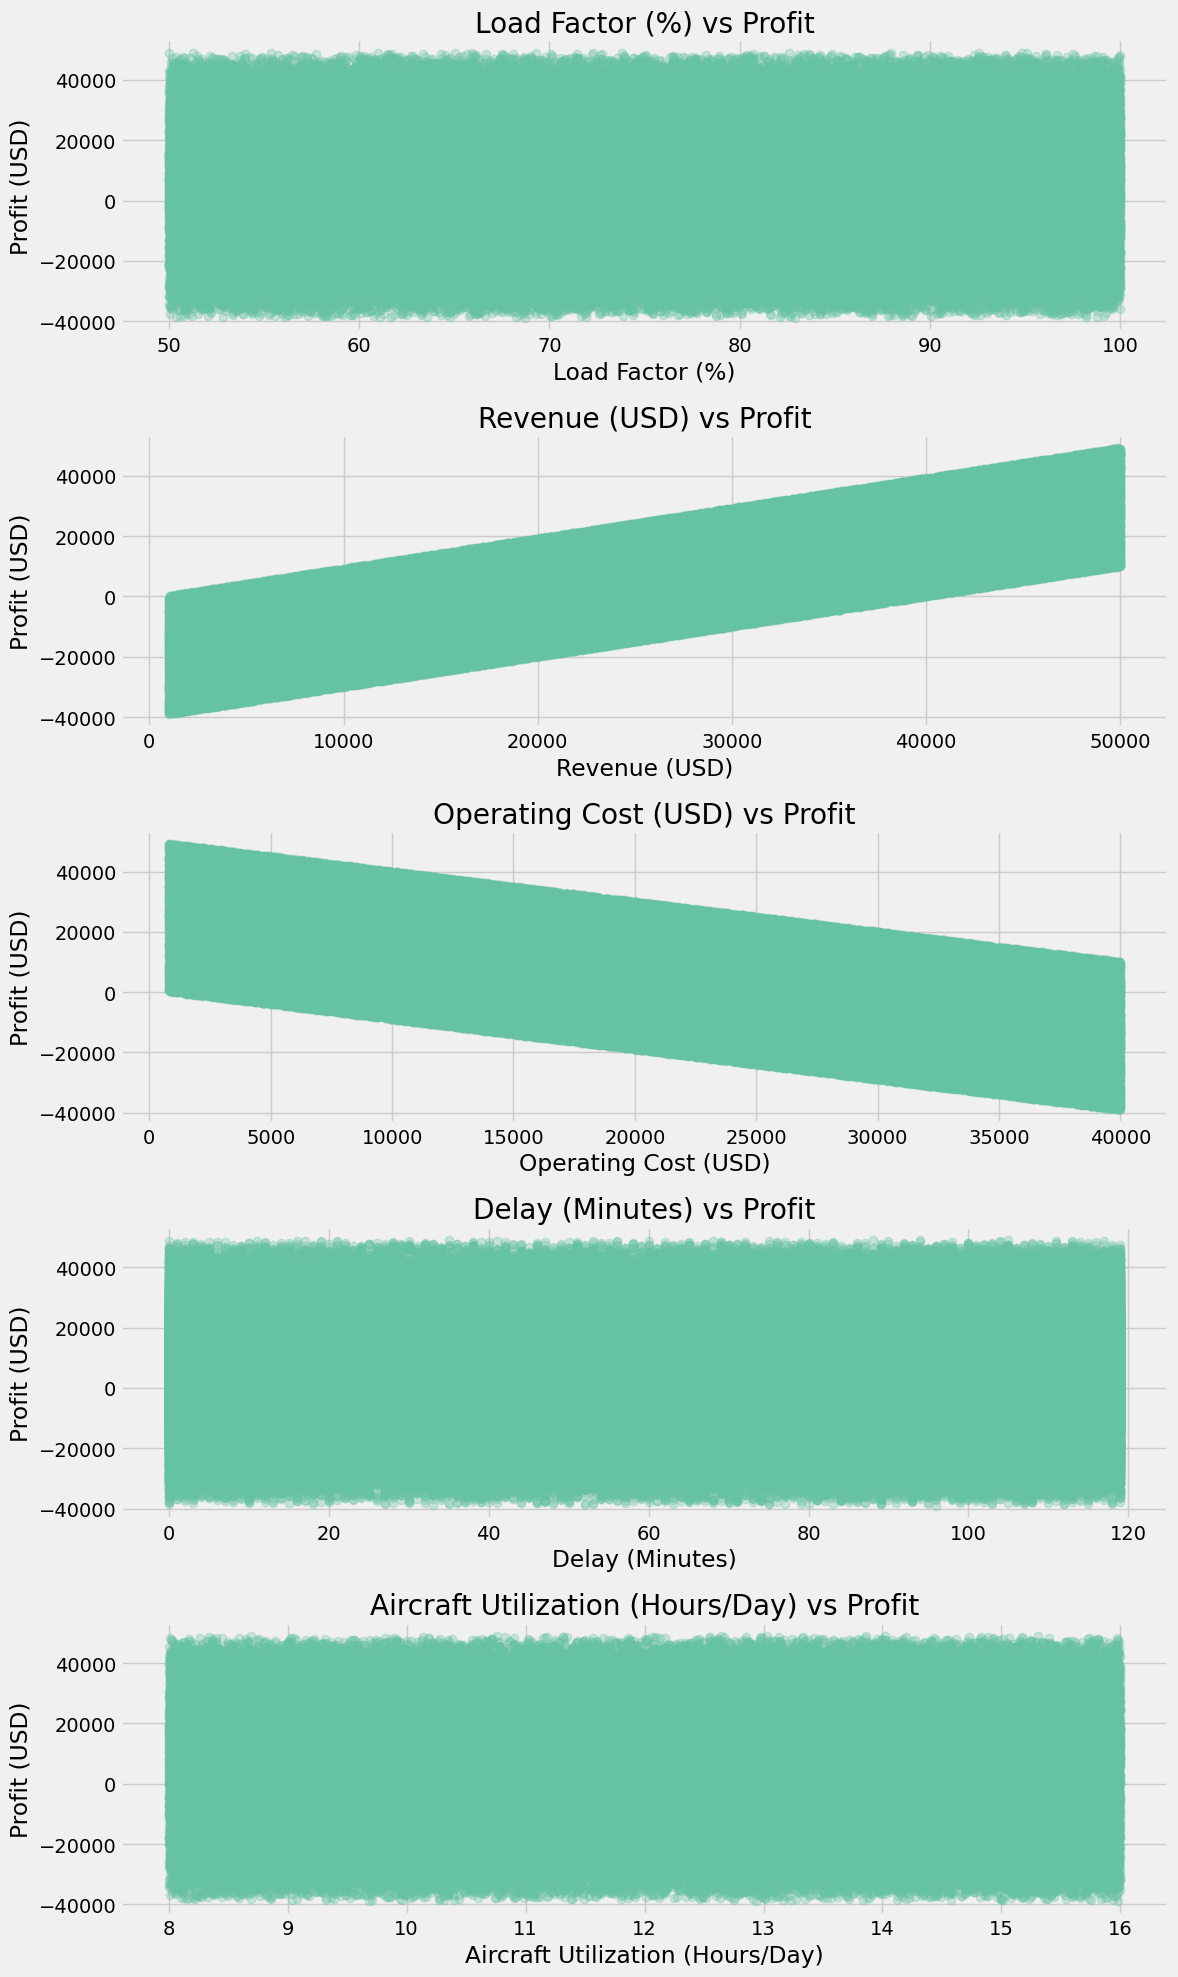

In [15]:
# Key feature relationships with Profit
key_features = ['Load Factor (%)', 'Revenue (USD)', 'Operating Cost (USD)',
                'Delay (Minutes)', 'Aircraft Utilization (Hours/Day)']

fig, axes = plt.subplots(len(key_features), 1, figsize=(12, 4*len(key_features)))
for i, feature in enumerate(key_features):
    sns.regplot(x=feature, y='Profit (USD)', data=df, scatter_kws={'alpha':0.3}, ax=axes[i])
    axes[i].set_title(f'{feature} vs Profit')
plt.tight_layout()
plt.show()

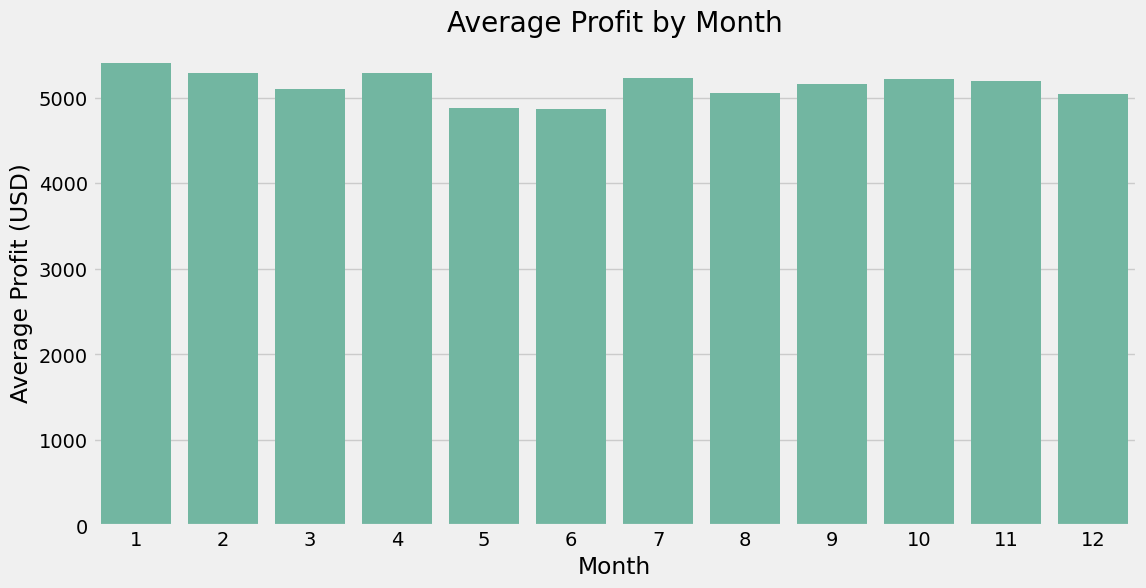

In [16]:
# Temporal analysis
# Convert datetime columns to datetime objects if they aren't already
df['Scheduled Departure Time'] = pd.to_datetime(df['Scheduled Departure Time'])
df['Actual Departure Time'] = pd.to_datetime(df['Actual Departure Time'])

# Extract month from scheduled departure
df['Month'] = df['Scheduled Departure Time'].dt.month

# Monthly average profit
monthly_profit = df.groupby('Month')['Profit (USD)'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='Profit (USD)', data=monthly_profit)
plt.title('Average Profit by Month')
plt.xlabel('Month')
plt.ylabel('Average Profit (USD)')
plt.show()


# **3. Data Preprocessing and Feature Engineering**

In [17]:
# Create a copy of the original dataframe to preserve it
df_processed = df.copy()

In [18]:
# 3.2 Extract temporal features
# From Scheduled Departure Time
df_processed['Scheduled_Year'] = df_processed['Scheduled Departure Time'].dt.year
df_processed['Scheduled_Month'] = df_processed['Scheduled Departure Time'].dt.month
df_processed['Scheduled_Day'] = df_processed['Scheduled Departure Time'].dt.day
df_processed['Scheduled_DayOfWeek'] = df_processed['Scheduled Departure Time'].dt.dayofweek
df_processed['Scheduled_Hour'] = df_processed['Scheduled Departure Time'].dt.hour


In [19]:
# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df_processed['Season'] = df_processed['Scheduled_Month'].apply(get_season)

In [20]:
# Create weekend/weekday feature
df_processed['Is_Weekend'] = df_processed['Scheduled_DayOfWeek'].isin([5, 6]).astype(int)

In [21]:
# Create time of day feature
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_processed['Time_Of_Day'] = df_processed['Scheduled_Hour'].apply(get_time_of_day)

In [22]:
# 3.3 Engineer new features from existing ones
# Operational efficiency metrics
df_processed['Delay_to_Turnaround_Ratio'] = df_processed['Delay (Minutes)'] / df_processed['Turnaround Time (Minutes)']
df_processed['Utilization_Efficiency'] = df_processed['Aircraft Utilization (Hours/Day)'] / 24  # Utilization vs. maximum possible

In [23]:
# Revenue and cost metrics
df_processed['Revenue_to_Cost_Ratio'] = df_processed['Revenue (USD)'] / df_processed['Operating Cost (USD)']
df_processed['Ancillary_to_Total_Revenue_Ratio'] = df_processed['Ancillary Revenue (USD)'] / df_processed['Revenue (USD)']
df_processed['Revenue_per_Load_Factor'] = df_processed['Revenue (USD)'] / df_processed['Load Factor (%)']
df_processed['Cost_per_Load_Factor'] = df_processed['Operating Cost (USD)'] / df_processed['Load Factor (%)']


In [24]:
# Maintenance and efficiency metrics
df_processed['Maintenance_to_Utilization_Ratio'] = df_processed['Maintenance Downtime (Hours)'] / df_processed['Aircraft Utilization (Hours/Day)']
df_processed['Fleet_Availability_to_Utilization'] = df_processed['Fleet Availability (%)'] / df_processed['Aircraft Utilization (Hours/Day)']

In [25]:
# Financial health metrics
df_processed['Operational_Margin'] = (df_processed['Revenue (USD)'] - df_processed['Operating Cost (USD)']) / df_processed['Revenue (USD)']

In [26]:
# 3.4 Encode categorical features
categorical_features = ['Season', 'Time_Of_Day']
for feature in categorical_features:
    dummies = pd.get_dummies(df_processed[feature], prefix=feature, drop_first=True)
    df_processed = pd.concat([df_processed, dummies], axis=1)
    df_processed.drop(feature, axis=1, inplace=True)

In [27]:
# Display the processed dataframe
print(f"Processed dataframe shape: {df_processed.shape}")
df_processed.head()

Processed dataframe shape: (200000, 40)


,Flight Number,Scheduled Departure Time,Actual Departure Time,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),...,Cost_per_Load_Factor,Maintenance_to_Utilization_Ratio,Fleet_Availability_to_Utilization,Operational_Margin,Season_Spring,Season_Summer,Season_Winter,Time_Of_Day_Evening,Time_Of_Day_Morning,Time_Of_Day_Night
0,FL885,2024-05-20 11:51:21.328,2024-07-10 02:38:53.731,50,12.36,115,79.18,96.24,9.21,4.15,...,351.699798,0.745146,7.786408,-1.542288,True,False,False,False,True,False
1,FL930,2024-01-23 06:56:22.686,2024-07-07 02:53:44.150,27,14.53,83,98.59,80.49,1.55,3.93,...,15.867836,0.106676,5.539573,0.950489,False,False,True,False,True,False
2,FL478,2024-05-30 09:18:38.578,2024-12-05 01:00:54.473,108,10.73,87,67.44,97.90,2.06,4.26,...,452.177936,0.191985,9.123952,-1.225860,True,False,False,False,True,False
3,FL637,2024-08-15 05:21:46.814,2024-09-21 13:23:41.615,64,15.10,99,69.01,80.17,6.85,4.13,...,194.813650,0.453642,5.309272,0.663165,False,True,False,False,True,False
4,FL318,2024-07-25 15:29:58.467,2024-03-21 15:05:54.375,30,13.46,114,50.36,82.23,7.30,4.97,...,688.422955,0.542348,6.109212,-2.006464,False,True,False,False,False,False


# **4. Feature Selection and Target Definition**

In [28]:
# Define features and target
# Drop columns not needed for modeling
columns_to_drop = ['Flight Number', 'Scheduled Departure Time', 'Actual Departure Time',
                   'Scheduled_Year', 'Scheduled_Month', 'Scheduled_Day', 'Scheduled_DayOfWeek',
                   'Scheduled_Hour', 'Profit (USD)']  # We'll keep the original features and engineered ones

X = df_processed.drop(columns=columns_to_drop)
y = df_processed['Profit (USD)']

In [29]:
# 4.1 Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=20)  # Select top 20 features
X_selected = selector.fit_transform(X, y)

In [30]:
# Get selected feature names
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

print("Top selected features:")
selected_scores = selector.scores_[selected_features_mask]
feature_importance = pd.DataFrame({'Feature': selected_features, 'Score': selected_scores})
feature_importance = feature_importance.sort_values('Score', ascending=False)
print(feature_importance)

X_selected_df = X[selected_features]

Top selected features:
                             Feature          Score
3                      Revenue (USD)  312977.951710
12           Revenue_per_Load_Factor  216501.872046
6                    Revenue per ASK  174980.018213
4               Operating Cost (USD)  127704.058246
14                Operational_Margin  115483.688035
13              Cost_per_Load_Factor   99171.043642
10             Revenue_to_Cost_Ratio   95293.835575
7                       Cost per ASK   84682.172495
11  Ancillary_to_Total_Revenue_Ratio   39643.458449
19                 Time_Of_Day_Night       2.751188
17                     Season_Winter       2.437725
1             Fleet Availability (%)       2.373118
16                     Season_Summer       1.736414
8                              Month       1.144261
15                     Season_Spring       0.749129
9             Utilization_Efficiency       0.690323
0   Aircraft Utilization (Hours/Day)       0.690323
18               Time_Of_Day_Evening     

In [31]:
# 4.2 Alternative selection with Random Forest feature importance
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(X, y)
rf_importances = rf_selector.feature_importances_

rf_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_importances})
rf_feature_importance = rf_feature_importance.sort_values('Importance', ascending=False)
print("\nRandom Forest feature importance:")
print(rf_feature_importance.head(20))


Random Forest feature importance:
                              Feature    Importance
18              Revenue_to_Cost_Ratio  4.465430e-01
24                 Operational_Margin  4.442303e-01
7                       Revenue (USD)  7.928758e-02
8                Operating Cost (USD)  2.992579e-02
9               Net Profit Margin (%)  8.596873e-07
11               Debt-to-Equity Ratio  8.430582e-07
4              Fleet Availability (%)  8.347169e-07
2           Turnaround Time (Minutes)  7.824474e-07
16          Delay_to_Turnaround_Ratio  6.911737e-07
0                     Delay (Minutes)  6.895180e-07
23  Fleet_Availability_to_Utilization  6.836582e-07
5        Maintenance Downtime (Hours)  6.816097e-07
21               Cost_per_Load_Factor  6.639964e-07
22   Maintenance_to_Utilization_Ratio  6.620538e-07
14                              Month  5.787091e-07
20            Revenue_per_Load_Factor  5.615781e-07
19   Ancillary_to_Total_Revenue_Ratio  5.543276e-07
10            Ancillary Reven

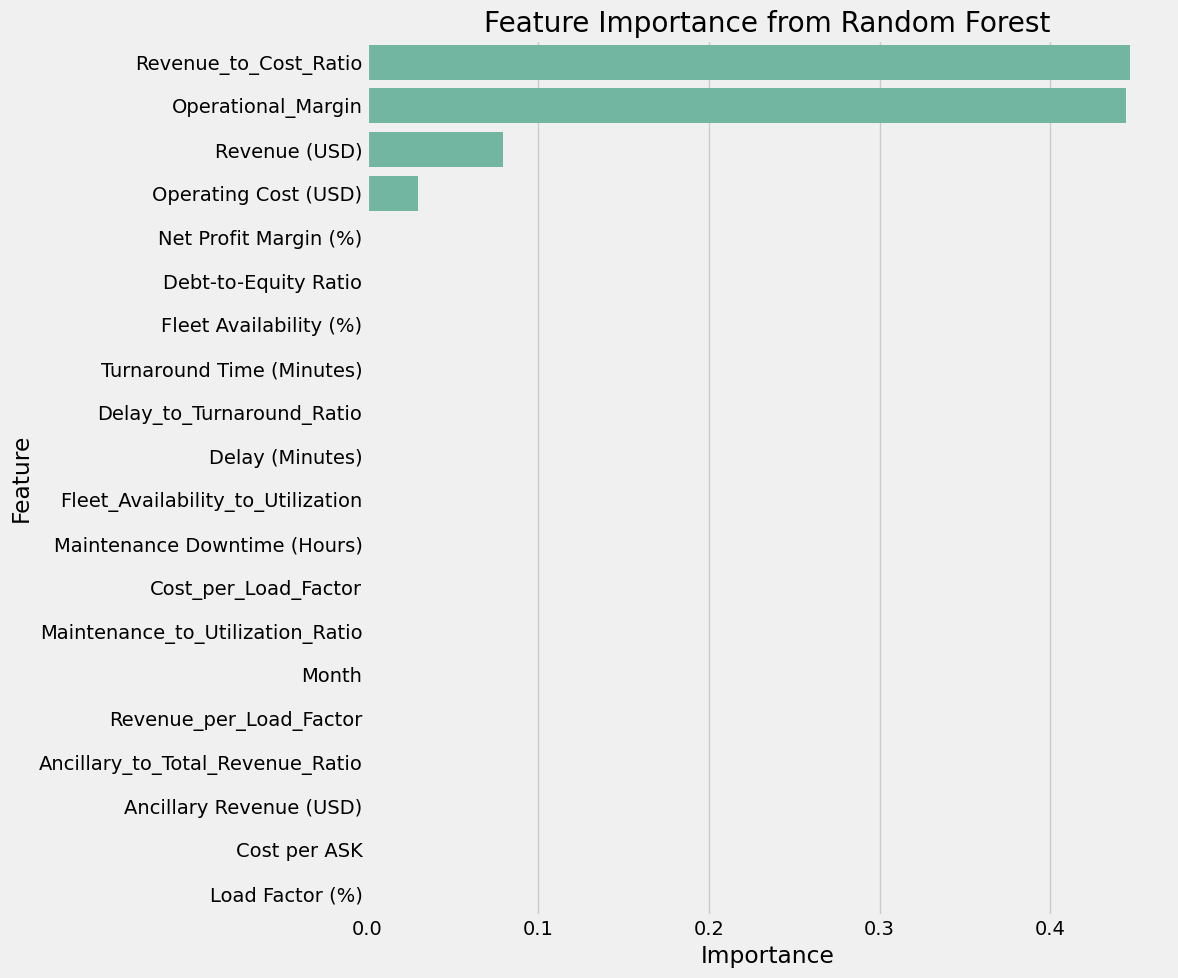

In [32]:
# Visualize feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.head(20))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()


In [33]:
# Let's use the Random Forest selected features for further modeling
top_features = rf_feature_importance['Feature'].head(20).tolist()
X_rf_selected = X[top_features]

# Use a combination of both selection methods
final_features = list(set(selected_features) | set(top_features))
X_final = X[final_features]
print(f"\nFinal dataset shape: {X_final.shape}")


Final dataset shape: (200000, 29)


# **5. Train-Test Split and Scaling**

---



In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X_final and y are already prepared
# Stratify using profit bins (computed once)
y_bins = pd.qcut(y, q=5, labels=False, duplicates='drop')

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y_bins
)

# Reuse the same binning method for train-validation split
y_train_bins = pd.qcut(y_train, q=5, labels=False, duplicates='drop')

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train_bins
)

# Print dataset shapes
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Training set: (120000, 29), (120000,)
Validation set: (40000, 29), (40000,)
Test set: (40000, 29), (40000,)


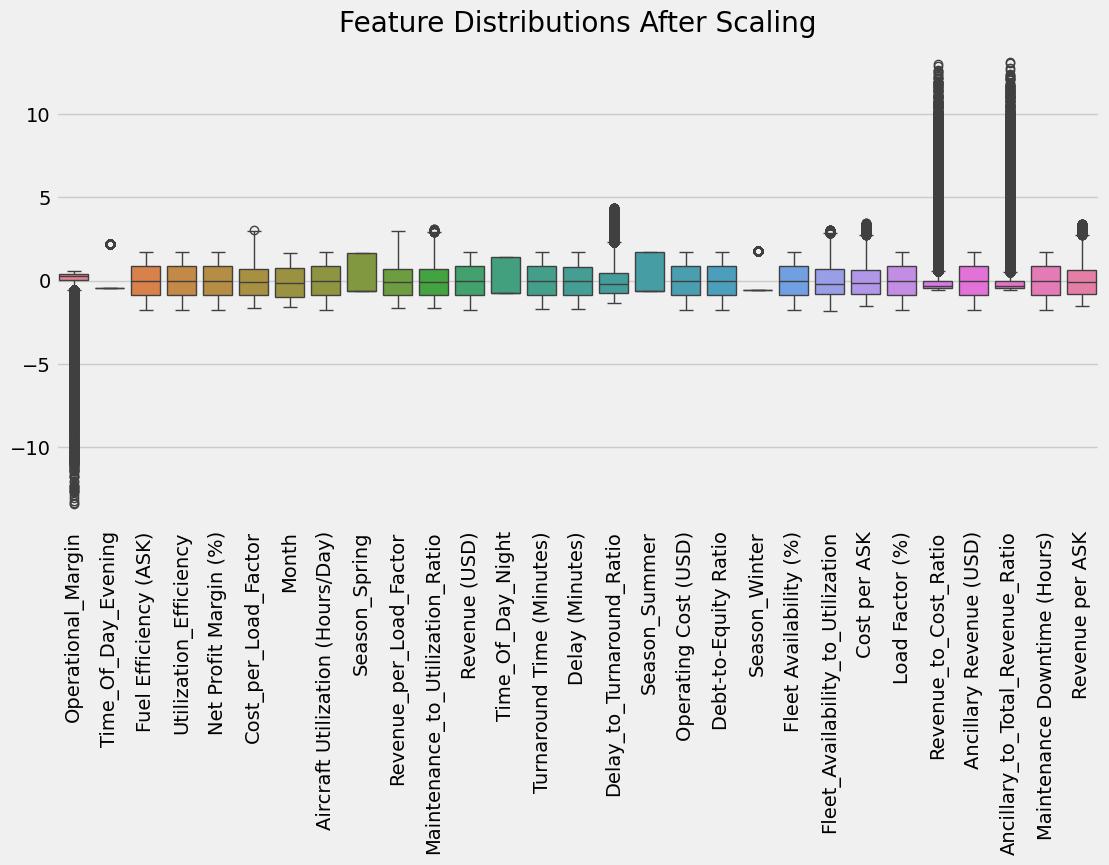

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_scaled)
plt.xticks(rotation=90)
plt.title("Feature Distributions After Scaling")
plt.show()


# **6. Baseline Model Implementation**

In [36]:
# 6.1 Train a set of baseline models
baseline_models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
}

In [37]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_val, y_val, name="Model"):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)

    # Print results
    print(f"{name} performance:")
    print(f"  Training RMSE: ${train_rmse:.2f}")
    print(f"  Validation RMSE: ${val_rmse:.2f}")
    print(f"  Training R²: {train_r2:.4f}")
    print(f"  Validation R²: {val_r2:.4f}")
    print(f"  Training MAE: ${train_mae:.2f}")
    print(f"  Validation MAE: ${val_mae:.2f}")
    print("-" * 50)

    return {
        'model': model,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'train_mae': train_mae,
        'val_mae': val_mae
    }


Random Forest performance:
  Training RMSE: $18.64
  Validation RMSE: $44.84
  Training R²: 1.0000
  Validation R²: 1.0000
  Training MAE: $13.44
  Validation MAE: $32.16
--------------------------------------------------
XGBoost performance:
  Training RMSE: $142.80
  Validation RMSE: $146.22
  Training R²: 0.9999
  Validation R²: 0.9999
  Training MAE: $112.28
  Validation MAE: $115.27
--------------------------------------------------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5586
[LightGBM] [Info] Number of data points in the train set: 120000, number of used features: 29
[LightGBM] [Info] Start training from score 5137.090566
LightGBM performance:
  Training RMSE: $186.54
  Validation RMSE: $189.68
  Training R²: 0.9999
  Validation R²: 0.9999
  Training M

<Figure size 1200x600 with 0 Axes>

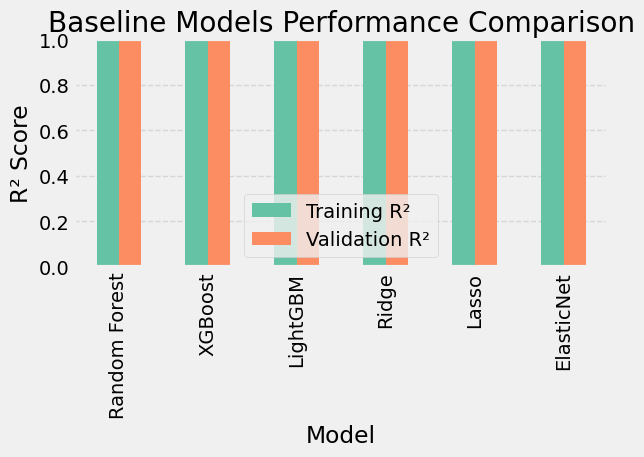

In [38]:
# Evaluate each baseline model
baseline_results = {}
for name, model in baseline_models.items():
    baseline_results[name] = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, y_val, name)

# Find the best performing model
best_baseline = max(baseline_results.items(), key=lambda x: x[1]['val_r2'])
print(f"Best baseline model: {best_baseline[0]} with validation R² of {best_baseline[1]['val_r2']:.4f}")

# Visualize baseline model performance
baseline_comparison = pd.DataFrame({
    'Model': list(baseline_results.keys()),
    'Training R²': [result['train_r2'] for result in baseline_results.values()],
    'Validation R²': [result['val_r2'] for result in baseline_results.values()],
    'Validation RMSE': [result['val_rmse'] for result in baseline_results.values()]
})

plt.figure(figsize=(12, 6))
baseline_comparison.set_index('Model')[['Training R²', 'Validation R²']].plot(kind='bar')
plt.title('Baseline Models Performance Comparison')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **------------------ The Given Data set is tooo eassy for the logistic regression model butt is we change the deat in this niche make more complex data then my diff complex models willl highly best useable**
**---Random Forest
XGBoost
LightGBM
Ridge Regression
Lasso Regression
ElasticNet----
------------------------------**

In [47]:
# Fixes if overfitted so used lineaRegression but the dataset is tooooo easy

from sklearn.linear_model import LinearRegression

# Use Linear Regression instead of Ridge
final_model = LinearRegression()
final_model.fit(X_train_scaled, y_train)

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Final Model Performance on Test Set:")
print(f"  Test RMSE: ${test_rmse:.2f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: ${test_mae:.2f}")

Final Model Performance on Test Set:
  Test RMSE: $0.00
  Test R²: 1.0000
  Test MAE: $0.00


In [48]:
import pandas as pd

# Compute correlation of features with the target variable
correlation_with_target = pd.Series(X_train_scaled.corrwith(y_train), name="Correlation")

# Sort by absolute correlation (strongest relationships first)
correlation_with_target = correlation_with_target.abs().sort_values(ascending=False)

# Display the top correlated features
print("Top 10 correlated features with the target variable:")
print(correlation_with_target.head(10))

Top 10 correlated features with the target variable:
Time_Of_Day_Evening                 0.009808
Season_Summer                       0.007054
Operational_Margin                  0.006492
Load Factor (%)                     0.006477
Ancillary_to_Total_Revenue_Ratio    0.005076
Fleet Availability (%)              0.005010
Delay_to_Turnaround_Ratio           0.004774
Net Profit Margin (%)               0.004741
Cost_per_Load_Factor                0.004727
Delay (Minutes)                     0.004489
Name: Correlation, dtype: float64


# **Test Set Evaluation**

In [49]:
# Final evaluation on test set
final_model = Ridge(alpha=1.0, random_state=42)  # Using best model
final_model.fit(X_train_scaled, y_train)

# Make predictions on test set
test_predictions = final_model.predict(X_test_scaled)

# Calculate metrics
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_r2 = r2_score(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Final Model Performance on Test Set:")
print(f"  Test RMSE: ${test_rmse:.2f}")
print(f"  Test R²: {test_r2:.4f}")
print(f"  Test MAE: ${test_mae:.2f}")


Final Model Performance on Test Set:
  Test RMSE: $0.97
  Test R²: 1.0000
  Test MAE: $0.66


# **Model Explainability Analysis**

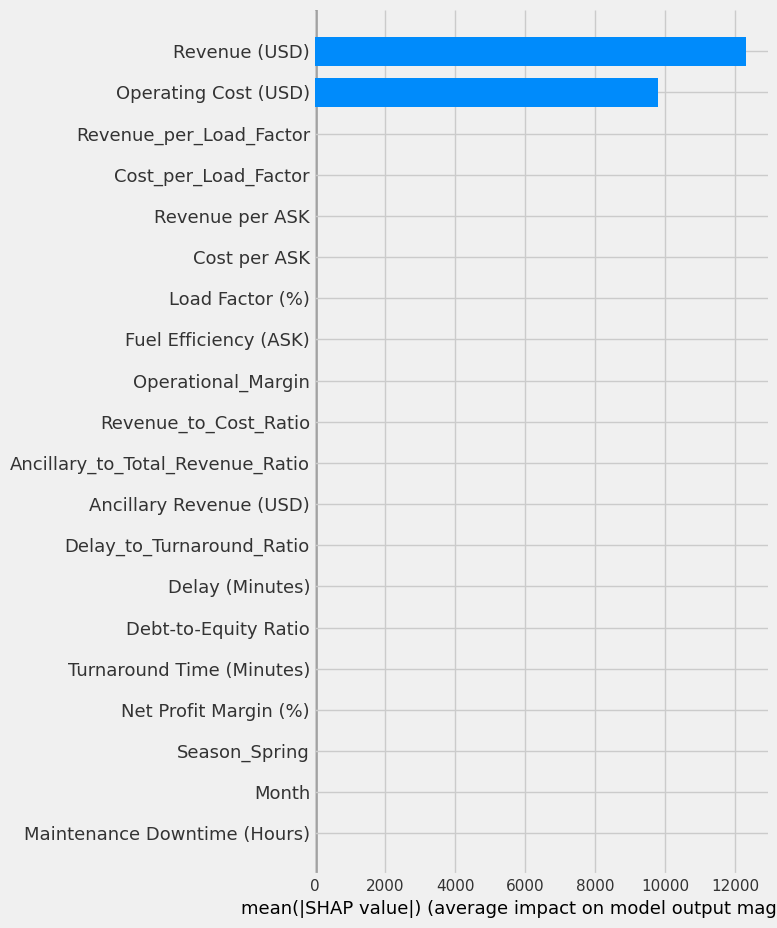

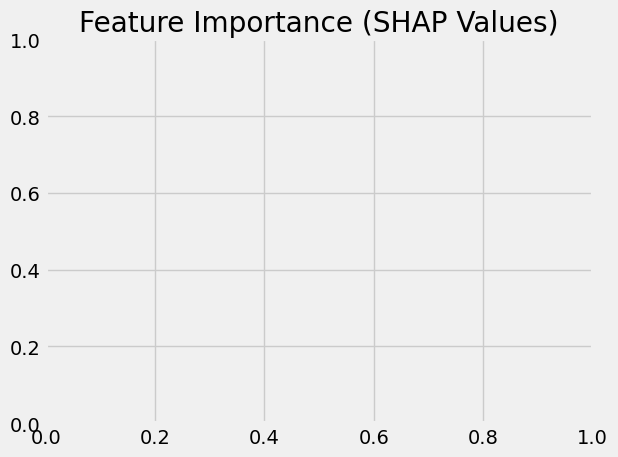

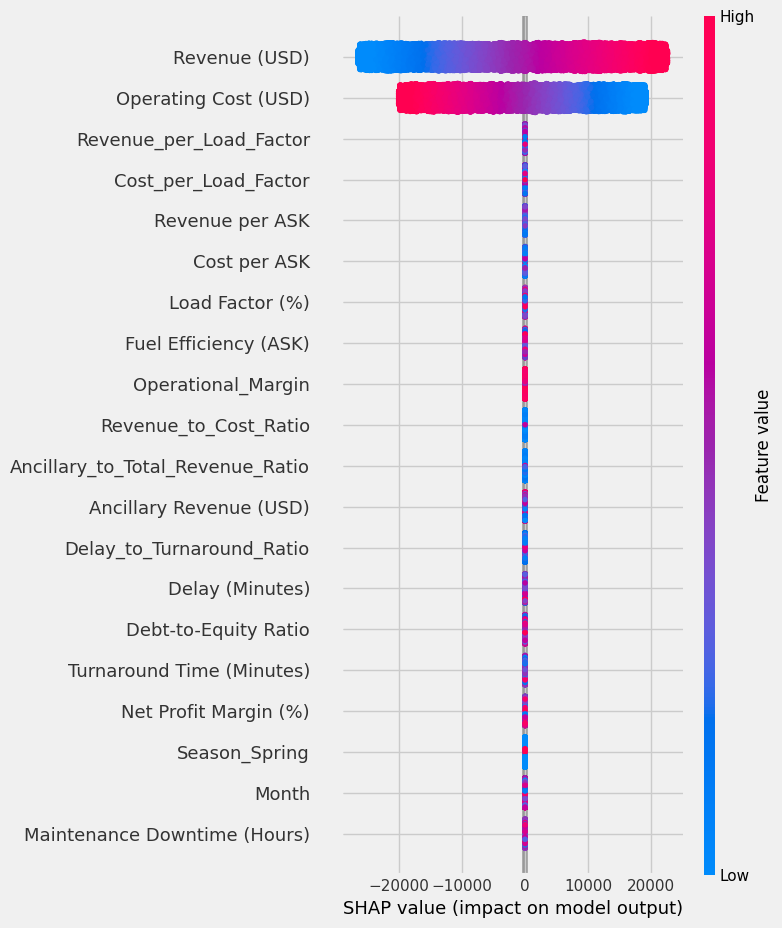

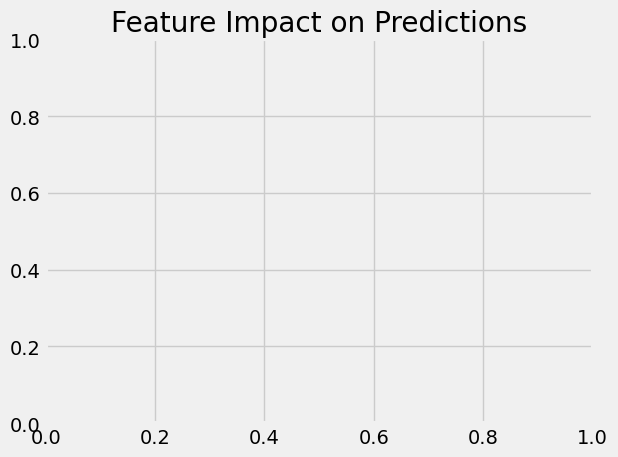

In [50]:
# Generate SHAP values
explainer = shap.Explainer(final_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Summary plot showing feature importance
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar")
plt.title('Feature Importance (SHAP Values)')
plt.tight_layout()
plt.show()

# Detailed SHAP summary plot showing feature impact direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled)
plt.title('Feature Impact on Predictions')
plt.tight_layout()
plt.show()

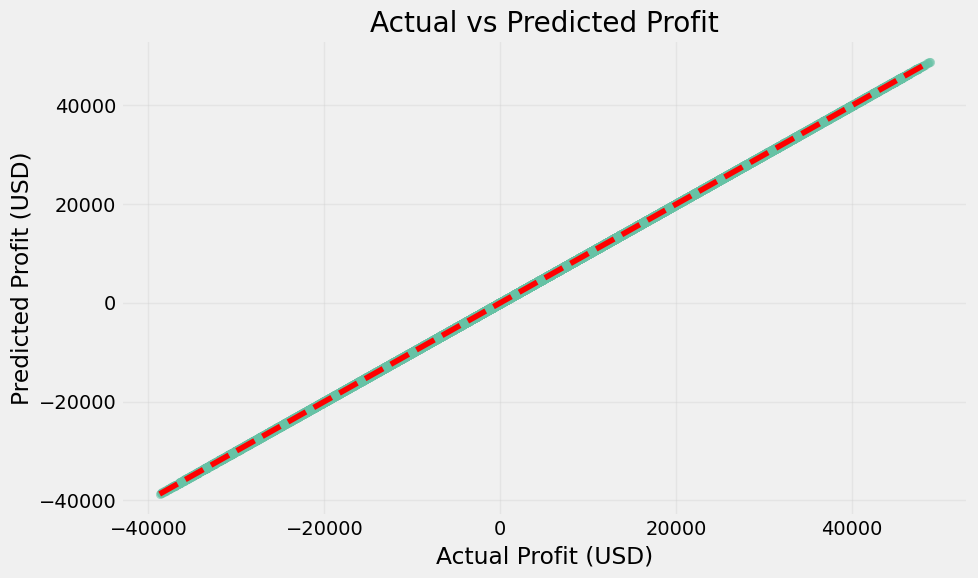

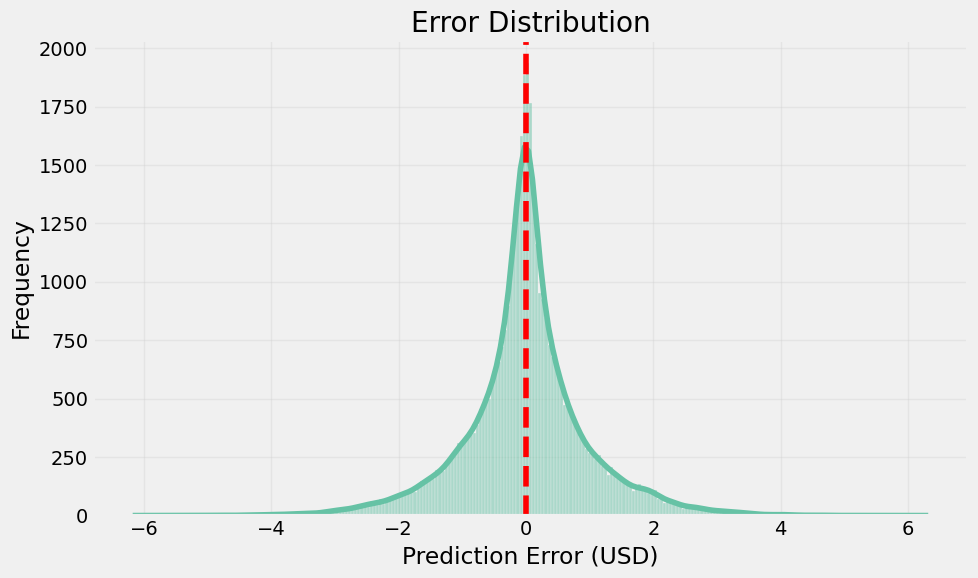

In [51]:
# Calculate prediction errors
errors = y_test - test_predictions
error_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Error': errors,
    'Absolute Error': np.abs(errors)
})

# Add original features for analysis
error_df = pd.concat([error_df, X_test.reset_index(drop=True)], axis=1)

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Profit (USD)')
plt.ylabel('Predicted Profit (USD)')
plt.title('Actual vs Predicted Profit')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error distribution
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Prediction Error (USD)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [52]:
# Identify and analyze high error cases
high_error_threshold = np.percentile(error_df['Absolute Error'], 95)
high_error_cases = error_df[error_df['Absolute Error'] > high_error_threshold]

print(f"Analysis of high error cases (top 5%):")
print(f"Number of high error cases: {len(high_error_cases)}")
print(f"Average absolute error: ${high_error_cases['Absolute Error'].mean():.2f}")

# Summary statistics of high error cases
high_error_stats = high_error_cases.describe().T
print(high_error_stats)

Analysis of high error cases (top 5%):
Number of high error cases: 0
Average absolute error: $nan
                                   count  mean  std  min  25%  50%  75%  max
Actual                               0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Predicted                            0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Error                                0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Absolute Error                       0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Operational_Margin                   0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Fuel Efficiency (ASK)                0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Utilization_Efficiency               0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Net Profit Margin (%)                0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Cost_per_Load_Factor                 0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Month                                0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
Aircraft Utilization (Hours/Day)     0.0   NaN  NaN  Na

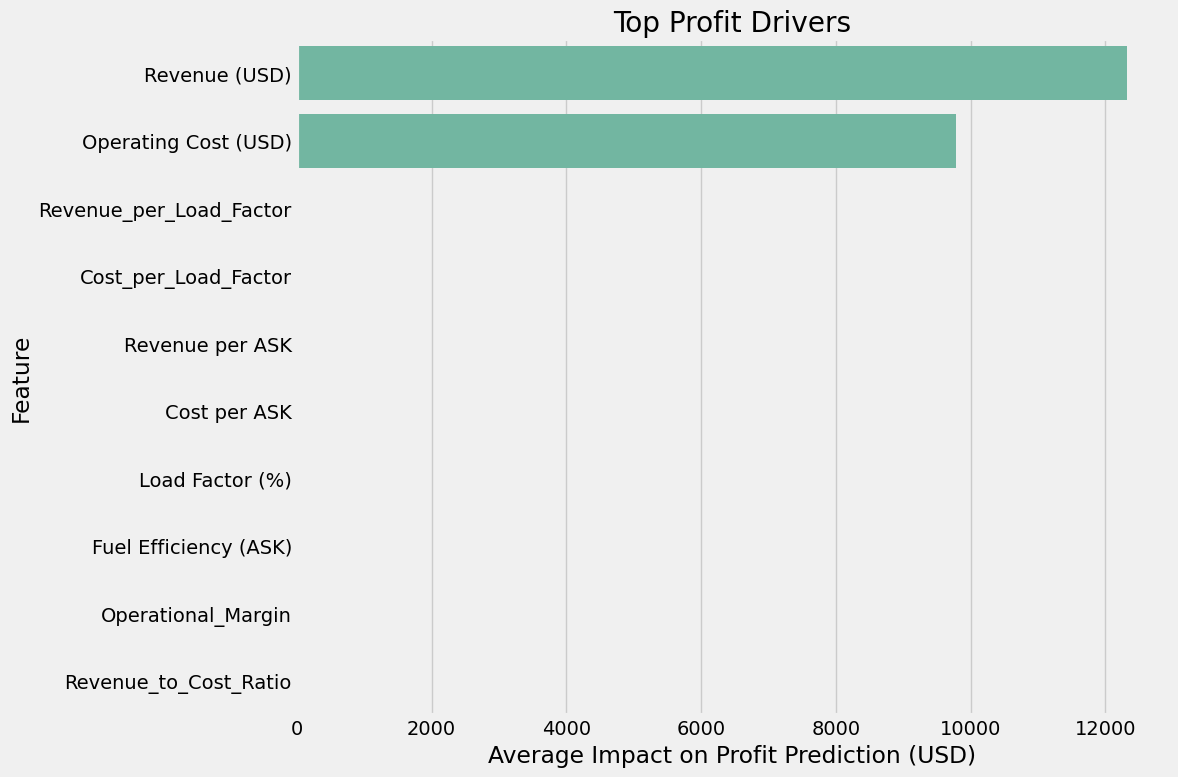

In [53]:
# Create comprehensive profit driver analysis
shap_df = pd.DataFrame(shap_values.values, columns=X_test_scaled.columns)
mean_shap_values = pd.DataFrame({
    'Feature': X_test_scaled.columns,
    'Mean SHAP Value': np.abs(shap_values.values).mean(axis=0)
})
mean_shap_values = mean_shap_values.sort_values('Mean SHAP Value', ascending=False)

# Visualize top profit drivers
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean SHAP Value', y='Feature', data=mean_shap_values.head(10))
plt.title('Top Profit Drivers')
plt.xlabel('Average Impact on Profit Prediction (USD)')
plt.tight_layout()
plt.show()
